# **Methylation Biomarkers for Predicting Cancer**

## **Random Forest for Feature Selection**

**Author:** Meg Hutch

**Date:** February 14, 2020

**Objective:** Use random forest to select genes for features in our deep learning classifier.

**Update**: Could try and choose a classifier maybe based off highest AUC and accuracy

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_score, recall_score, precision_recall_fscore_support, f1_score, log_loss
from sklearn.metrics import make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score

In [2]:
# set working directory for git hub
import os
os.chdir('/home/mrh1996/')
#os.chdir('C:\\Users\\User\\Box Sync/Projects/')
os. getcwd()

'/home/mrh1996'

**Import the training data**

In [3]:
mcTrain_x = pd.read_csv('Multi_Cancer_DL/02_Processed_Data/Final_Datasets/mcTrain_x_Full_70_30.csv')
mcTrain_y = pd.read_csv('Multi_Cancer_DL/02_Processed_Data/Final_Datasets/mcTrain_y_Full_70_30.csv')

**Drop Un-neccessary columns**

In [4]:
mcTrain_x = mcTrain_x.drop(columns=["dilute_library_concentration", "age", "gender", "frag_mean"])

**Convert seq_num id to index**

In [5]:
mcTrain_x = mcTrain_x.set_index('id')
mcTrain_y = mcTrain_y.set_index('id')

**Split Training Data into a training/validation**

In [6]:
from sklearn.model_selection import train_test_split
np.random.seed(21420)
X_train, X_test, y_train, y_test = train_test_split(mcTrain_x, mcTrain_y, test_size=0.25, random_state=25, shuffle = True, stratify = mcTrain_y)

**Examine Disease Distributions After Training/Testing Split**

In [7]:
y_train_perc = y_train.groupby(['diagnosis']).size()/len(y_train)*100
y_test_perc = y_test.groupby(['diagnosis']).size()/len(y_test)*100

#print(y_train_perc)
#print(y_test_perc)

**One-hot encode y classes**

In [1]:
from sklearn import preprocessing
y_train_multi = preprocessing.label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5, 6])
y_test_multi = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

NameError: name 'y_train' is not defined

**Convert to arrays**

In [9]:
# save copy of X_train - this will be used for feature selection down the line
X_train_orig = X_train

# Convert all to arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values 
y_test = y_test.values

# Convert y_train to 1D
y_train = y_train.ravel()

# test
#print(y_test.reshape(1,-1)) 

# Feb 22 test
#y_train = y_train.reshape(1,-1)
#y_test = y_test.reshape(1,-1)

# **Random Forest**

The hyperparameter tuning function was adapted from Garrett's modeling lecture:

https://github.com/geickelb/HSIP442_guest_lecture/blob/master/notebooks/modeling.ipynb

scoring parameter for multi-classification: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter (will try f1_samples and precision_samples and/or just accuracy)

**Define scoring function**

In [10]:
#scoring = ['AUC', 'Accuracy']

**Define Random Forest Hypertuning Function**

In [11]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring = 'roc_auc_ovo_weighted', verbose=True, cv = True, 
                    return_train_score = True): 
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    np.random.seed(12345)
    
    # The scorers can be either be one of the predefined metric strings or a scorer
    # callable, like the one returned by make_scorer
    #scoring = {'AUC': 'roc_auc_ovr', 'Accuracy': make_scorer(accuracy_score)}

    grid_search = GridSearchCV(estimator= model,
                                     param_grid=param_grid,
                                     cv=StratifiedKFold(nfolds), # stratified k-folds will preserve class balances - this function is what got the rest of the code to work with roc validation
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1)
    
    #scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc_ovr'}
    #scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
    
    #OneVsRestClassifier(grid_search.fit(X, y))   
    grid_search.fit(X, y)
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    return(grid_search)
    #print(grid_search.cv_results_)

**Tune Hyperparameters**

In [12]:
### tuning RF hyperparameters
# Number of trees in random forest
n_estimators = [100, 300, 500, 1000] #  100, 300, 500, 1000
# Number of features to consider at every split
max_features = [3, 10, 'auto'] # 'auto' which is equivalent to sqrt(n_features)
# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10, 15]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

model = RandomForestClassifier(criterion='entropy', random_state=12345)

rf_hyper=hypertuning_fxn(X_train, y_train, nfolds=10, model=model , param_grid=param_grid, scoring= 'roc_auc_ovo_weighted', cv = True, return_train_score = True)

 scorer function: roc_auc_ovo_weighted
 ##### CV performance: mean & sd scores #####
best cv score: 0.722
best cv params:  {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
worst cv score: 0.642
worst cv params:  {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 100}
0.654 (+/-0.175) for {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.668 (+/-0.173) for {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.666 (+/-0.183) for {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.674 (+/-0.190) for {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.652 (+/-0.152) for {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1

**Return the Best Estimator**

In [13]:
print(rf_hyper.best_estimator_)
rf = rf_hyper.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


# **Evaluate Model**

In [14]:
print(rf_hyper.classes_) # number of classes - this is an attribute of the rf classifier

# predict the probabilities of the classifier when applied to the test set - Note: [:,] shapes data into the right format for multiclass
rf_probs = rf_hyper.best_estimator_.predict_proba(X_test)[:,]
#rf_probs.shape

[0 1 2 3 4 5 6]


In [15]:
rf_preds = rf_hyper.best_estimator_.predict(X_test)[:,]
#rf_preds = rf_preds.reshape(-1,1).shape
#rf_preds

**Note:** ovr computes the AUC of each class against the rest [3] [4]. This treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance even when average == 'macro', because class imbalance affects the composition of each of the ‘rest’ groupings"

Weighted: Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

In [16]:
#roc_auc_score(y_test, rf_probs, multi_class = 'ovr', average = 'weighted') # multi_class must be in ('ovo', 'ovr')

print('Roc_Auc_Score:')
roc_auc_score(y_test_multi, rf_probs, multi_class = 'ovo', average = 'weighted') # multi_class must be in ('ovo', 'ovr')#

Roc_Auc_Score:


0.6808267370246802

# **Confusion Matrix**

In [17]:
rf_preds = rf_hyper.best_estimator_.predict(X_test)[:,]
confusion_matrix(y_test, rf_preds)

array([[12,  2,  0,  1,  0,  0,  0],
       [ 7,  2,  0,  0,  2,  0,  0],
       [ 5,  0,  0,  0,  0,  1,  0],
       [ 6,  1,  0,  4,  0,  1,  0],
       [ 1,  2,  0,  3,  1,  0,  0],
       [ 2,  1,  0,  2,  0,  0,  0],
       [ 2,  0,  0,  3,  0,  0,  0]])

In [18]:
target_names = ['HEA', 'CRC', 'ESCA', 'HCC', 'STAD', 'GBM', 'BRCA']
print(classification_report(y_test, rf_preds, target_names=target_names))

              precision    recall  f1-score   support

         HEA       0.34      0.80      0.48        15
         CRC       0.25      0.18      0.21        11
        ESCA       0.00      0.00      0.00         6
         HCC       0.31      0.33      0.32        12
        STAD       0.33      0.14      0.20         7
         GBM       0.00      0.00      0.00         5
        BRCA       0.00      0.00      0.00         5

    accuracy                           0.31        61
   macro avg       0.18      0.21      0.17        61
weighted avg       0.23      0.31      0.24        61



/home/mrh1996/.conda/envs/envs_dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Examine Important Features**

Feature Importance for Multi-class classification:
https://stackoverflow.com/questions/54562464/can-i-show-feature-importance-for-multioutputclassifier

MultiOutputClassifier objects have an attribute called estimators_. If you run multi_forest.estimators_, you will get a list containing an object for each of your RandomForest classifiers.

For each of these RandomForest classifier objects, you can access its feature importances through the feature_importances_ attribute.

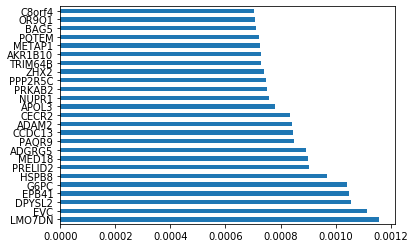

In [19]:
# create empty list
feat_impts = [] 
# bind all rf estimators for each classifier (each multi-class output - in our case 7)
for clf in rf.estimators_:
    feat_impts.append(clf.feature_importances_)

# calculate the mean of features across genes
feat = np.mean(feat_impts, axis=0)
# create a list of features (gene names)
features = list(X_train_orig.columns.values) 
# add gene names to the means
feat_importances = pd.Series(feat, index=X_train_orig.columns)  

# plot feature importance for nlargest means 
feat_importances.nlargest(25).plot(kind='barh')

# **Save List of Features**

In [20]:
#feat_100 = feat_importances.nlargest(100)
#feat_100
#feat_100.to_csv('Multi_Cancer_DL/02_Processed_Data/Final_Datasets/rf_100feats_FULL_70_30.csv')

feat_200 = feat_importances.nlargest(200)
feat_200
feat_200.to_csv('Multi_Cancer_DL/02_Processed_Data/Final_Datasets/rf_200feats_FULL_70_30.csv')